- Tanguy Malandain
- Hugo Deplagne
- Pierre Litoux
- Param Dave

# Clustering

We will first form clusters based on questions of type `usage` and then `attitude`. To achieve this, we need to determine the optimal number of clusters through various methods.

### Import modules

In [84]:
import pandas as pd
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


# Ignore the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

### Load dataframe

In [85]:
codes = 'data/fic_epita_kantar_codes.csv'
labels = 'data/fic_epita_kantar_labels.csv'

# Read the CSV file into a DataFrame
df_codes = pd.read_csv(codes, sep=';')

In [86]:
df_codes.head()

,cle,Respondent_ID,weight,A11,A12,A13,A14,A4,A5,A5bis,...,RS193,RS102RECAP,rs11recap2,RS11recap,RS193bis,RS2Recap,RS56Recap,RS2,RS11,RS102
0,1,MET20_999999996,2.501255,1,0,0,0,1,2.0,NaN,...,2,4,1,2,NaN,1,1,24,0,4
1,2,MET20_98888888,0.722914,1,0,0,0,1,5.0,NaN,...,2,1,1,2,NaN,4,1,50,0,1
2,3,MET20_1978307,1.039611,1,0,0,0,1,2.0,NaN,...,2,3,2,1,NaN,3,2,37,1,3
3,4,MET20_1302078,0.976590,1,1,1,0,1,1.0,NaN,...,2,2,1,2,NaN,5,3,63,0,2
4,5,MET20_1869308,0.812315,0,1,0,0,2,NaN,1.0,...,2,3,2,1,NaN,3,1,44,1,3


### Fill NaN values

In [87]:
columns_to_fill = ['A5', 'A5bis']
df_codes[columns_to_fill] = df_codes[columns_to_fill].fillna(0)

df_codes.iloc[:, 4:] = df_codes.iloc[:, 4:].fillna(df_codes.iloc[:, 4:].median())

### Separate usage and attitude questions

In [88]:
df_usage = df_codes.iloc[:, 0:30].copy()
df_attitude = df_codes.iloc[:, list(range(3)) + list(range(30, 67))].copy()

### Get optimal number of clusters

In [89]:
def calculate_clustering_scores(df_selected, kmeans):
    clusters = kmeans.fit_predict(df_selected)

    # Calcul du score de silhouette
    silhouette_avg = silhouette_score(df_selected, clusters)
    
    # Calcul des distances intra-cluster
    intra_distances = kmeans.transform(df_selected)
    intra_cluster_distance = np.mean(np.min(intra_distances, axis=1))
    
    # Calcul des distances inter-cluster
    cluster_centers = kmeans.cluster_centers_
    inter_cluster_distances = cdist(cluster_centers, cluster_centers, 'euclidean')
    # On prend la distance minimale entre les centres, en excluant les zéros de la diagonale
    inter_cluster_distance = np.min(inter_cluster_distances[np.nonzero(inter_cluster_distances)])
    
    return silhouette_avg, intra_cluster_distance, inter_cluster_distance


def plot_cluster_metrics(df):
    # Appliquer la méthode du coude pour trouver le nombre optimal de clusters
    sse = []
    silhouette_scores = []
    intra_cluster_distances = []
    inter_cluster_distances = []
    for k in range(2, 11):  # Testons de 2 à 10 clusters
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(df)
        sse.append(kmeans.inertia_)  # Somme des carrés des distances des échantillons à leur centre de cluster le plus proche
        silhouette_avg, intra_cluster_distance, inter_cluster_distance = calculate_clustering_scores(df, kmeans)
        silhouette_scores.append(silhouette_avg)
        intra_cluster_distances.append(intra_cluster_distance)
        inter_cluster_distances.append(inter_cluster_distance)


   # Créer une grille de sous-graphiques (2 lignes, 2 colonnes)
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # Tracer la courbe SSE par rapport au nombre de clusters
    axs[0, 0].plot(range(2, 11), sse, 'bx-')
    axs[0, 0].set_xlabel('Nombre de clusters')
    axs[0, 0].set_ylabel('SSE (Somme des carrés des erreurs)')
    axs[0, 0].set_title('La Méthode du Coude pour déterminer le nombre optimal de clusters')

    # Tracer la courbe de score de silhouette par rapport au nombre de clusters
    axs[0, 1].plot(range(2, 11), silhouette_scores, 'bx-')
    axs[0, 1].set_xlabel('Nombre de clusters')
    axs[0, 1].set_ylabel('Score de silhouette')
    axs[0, 1].set_title('Score de silhouette par rapport au nombre de clusters, à maximiser')

    # Tracer la courbe de distance intra-cluster par rapport au nombre de clusters
    axs[1, 0].plot(range(2, 11), intra_cluster_distances, 'bx-')
    axs[1, 0].set_xlabel('Nombre de clusters')
    axs[1, 0].set_ylabel('Distance intra-cluster')
    axs[1, 0].set_title('Distance intra-cluster par rapport au nombre de clusters, à minimiser')

    # Tracer la courbe de distance inter-cluster par rapport au nombre de clusters
    axs[1, 1].plot(range(2, 11), inter_cluster_distances, 'bx-')
    axs[1, 1].set_xlabel('Nombre de clusters')
    axs[1, 1].set_ylabel('Distance inter-cluster')
    axs[1, 1].set_title('Distance inter-cluster par rapport au nombre de clusters, à maximiser')

    # Ajuster l'espacement entre les sous-graphiques
    plt.tight_layout()

    # Afficher la grille de sous-graphiques
    plt.show() 


#### For usage questions

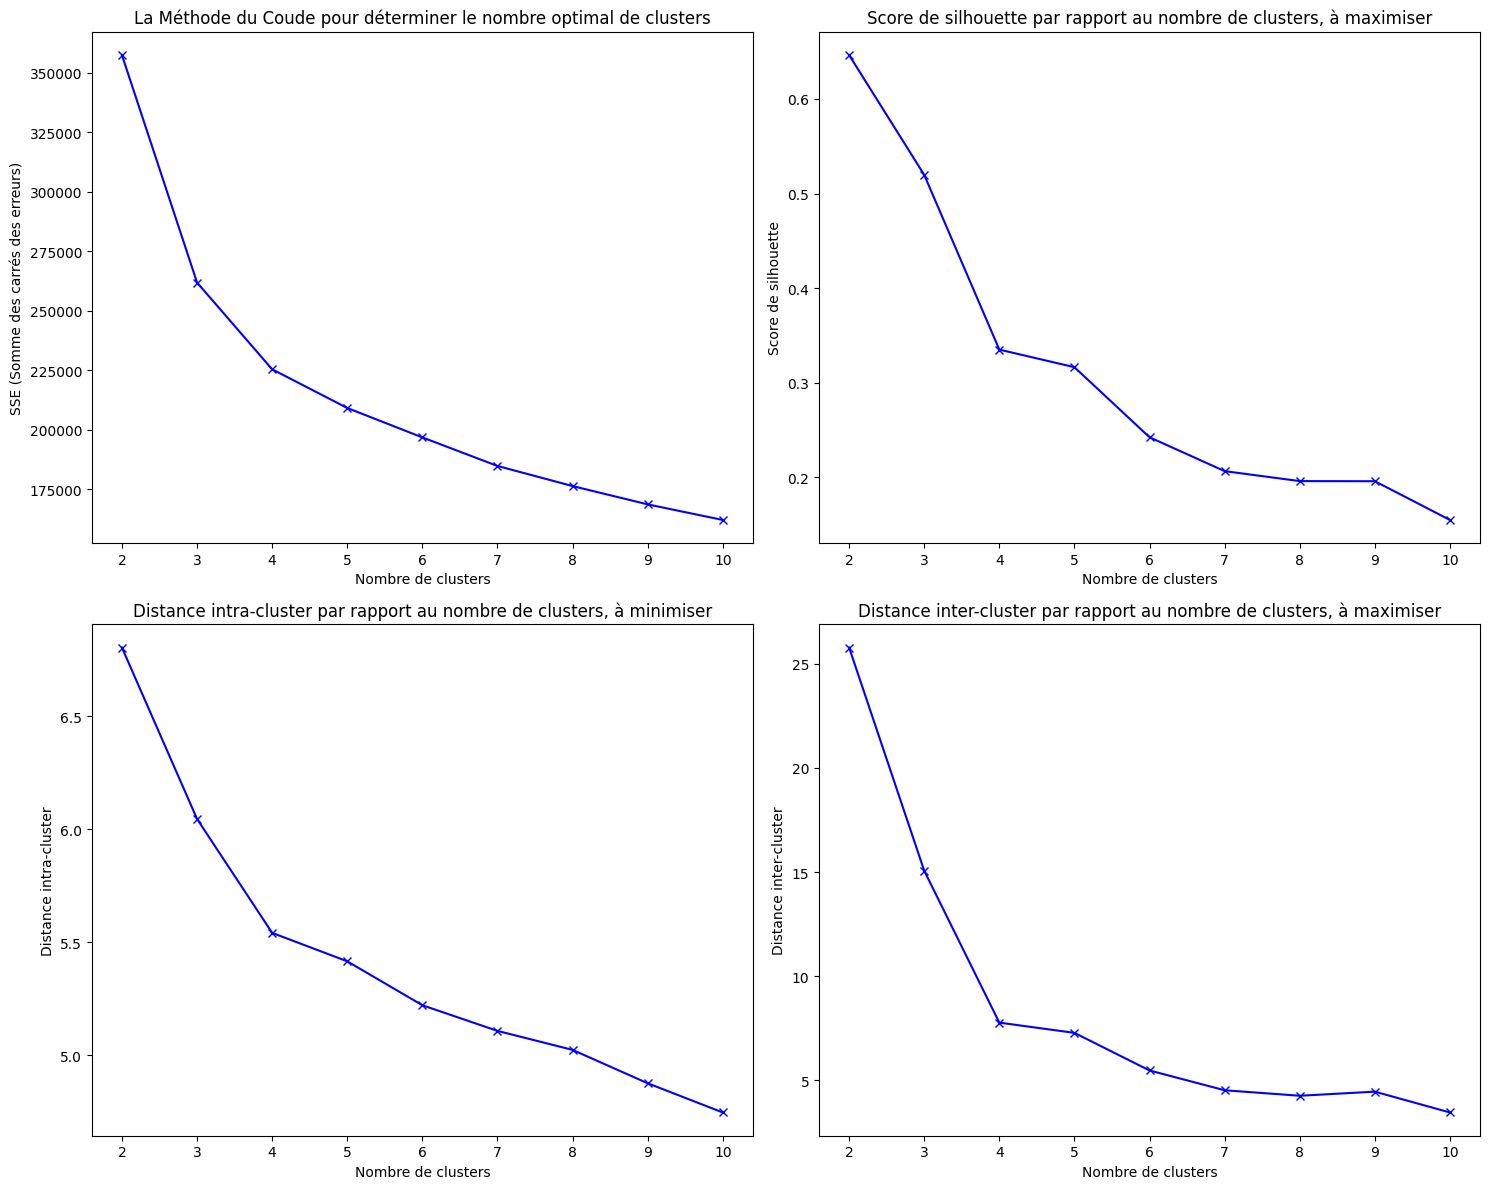

In [90]:
plot_cluster_metrics(df_usage.iloc[:, 3:])


Le nombre de cluster optimal peut être estime à `4`.

#### For attitude questions

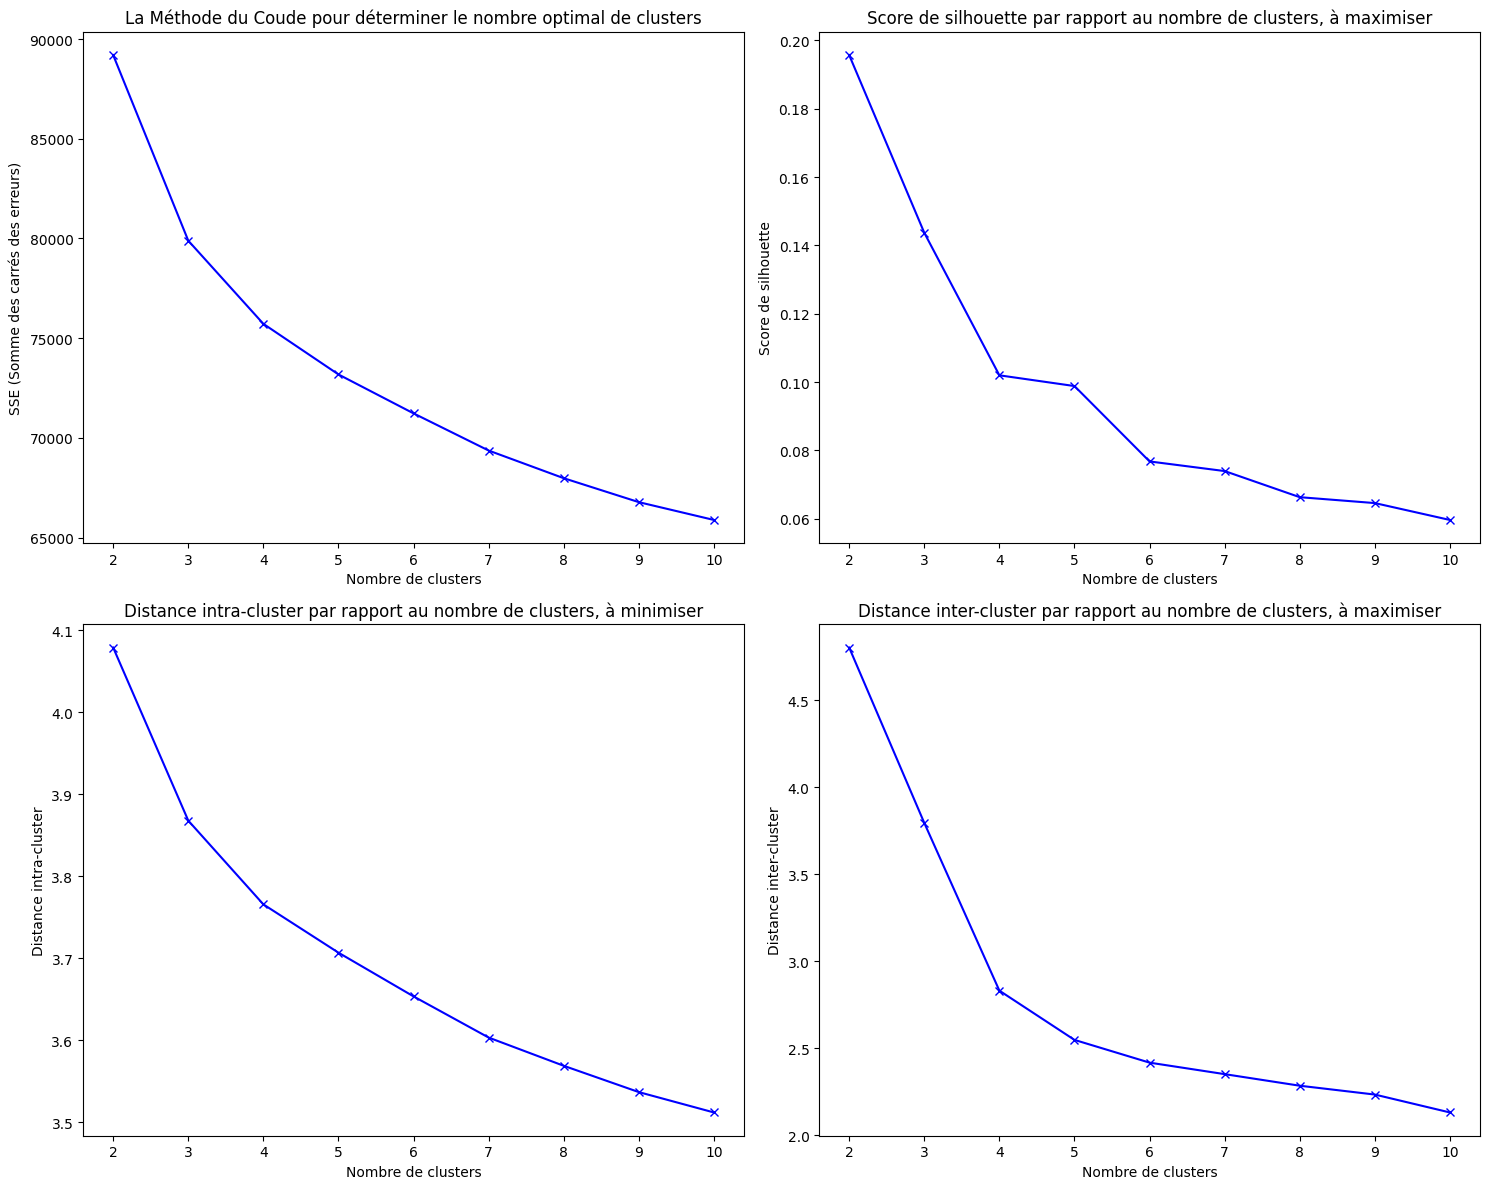

In [91]:
plot_cluster_metrics(df_attitude.iloc[:, 3:])

Le nombre de cluster optimal peut être estime à `4` aussi.

## Usage Clustering

In [92]:
def make_clusters(df, n):
    data = df.iloc[:, 3:]  # Extracting only the columns with answers

    # Standardize the data
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data)

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(data_standardized)

    # Visualize the clusters using PCA (for 3D visualization)
    pca = PCA(n_components=3)
    data_pca = pca.fit_transform(data_standardized)

    # Create an interactive 3D scatter plot using Plotly Express
    fig = px.scatter_3d(
        df,
        x=data_pca[:, 0],
        y=data_pca[:, 1],
        z=data_pca[:, 2],
        color='cluster',
        labels={'color': 'Cluster'},
        title='Clustering of Respondents (Interactive 3D)',
        width=1200,
        height=1200,
        size_max=35,
        opacity=1,
        size="weight"
    )

    fig.show()

    return kmeans

In [93]:
kmeans_usage = make_clusters(df_usage, 5)

## Explication des clusters

- ## Importance des features global pour la decision

In [94]:
def feature_importance(df):
    data = df.iloc[:, 3:-1] 
    
    # Standardize the data
    data = data.apply(pd.to_numeric, errors='ignore')
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data)

    # Train a simple model (Random Forest) to get feature importance
    model = RandomForestClassifier(random_state=42)
    model.fit(data_standardized, df['cluster'])

    # Get feature importances
    feature_importances = model.feature_importances_

    # Visualize feature importances
    plt.figure(figsize=(12, 6))
    sns.barplot(x=data.columns, y=feature_importances, palette='viridis')
    plt.title('Feature Importances across Clusters')
    plt.xticks(rotation=45, ha='right')
    plt.show()

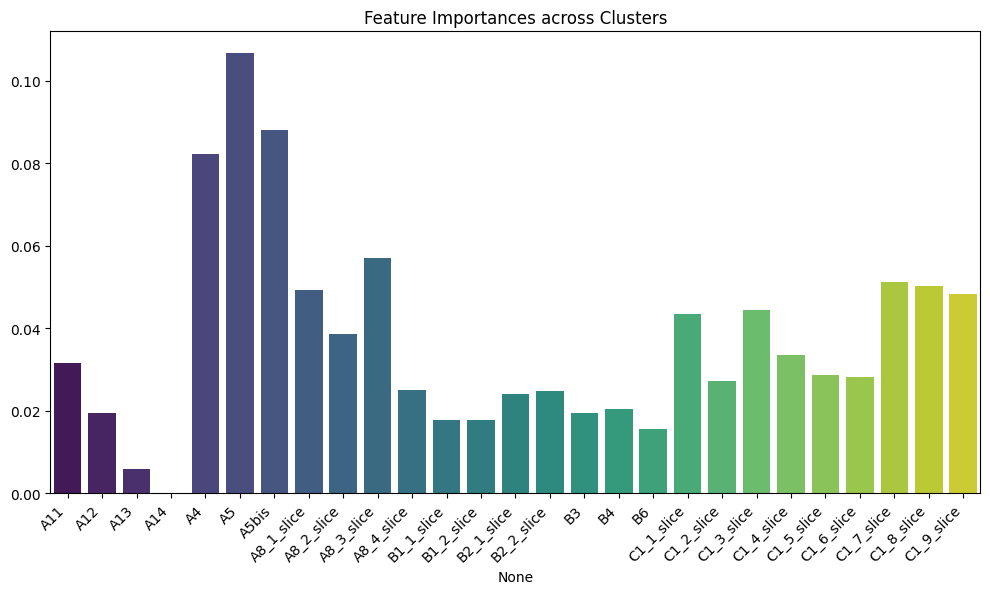

In [95]:
feature_importance(df_usage)

- ## Importance des features par cluster

In [96]:
def features_per_cluster(df, kmeans, n):
    # Extract cluster centers
    cluster_centers = kmeans.cluster_centers_
    
    # Create a DataFrame to store cluster centers with column names
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=df.columns)
    
    # Identify the most important features for each cluster
    most_important_features = {}
    
    for cluster in range(n):
        # Sort features by importance (absolute values) for the current cluster
        sorted_features = cluster_centers_df.iloc[cluster].abs().sort_values(ascending=False)
        
        # Get the top N most important features (you can adjust N)
        top_features = sorted_features.head(5)  # Change 5 to the desired number of top features
        
        # Store the result in the dictionary
        most_important_features[f'Cluster {cluster}'] = top_features.index.tolist()

    # Print or visualize the most important features for each cluster
    print("Most Important Features by Cluster:")
    for cluster, features in most_important_features.items():
        print(f"{cluster}: {features}")


In [97]:
features_per_cluster(df_usage.iloc[:, 3:-1], kmeans_usage, 5)

Most Important Features by Cluster:
Cluster 0: ['A4', 'A5bis', 'A11', 'C1_1_slice', 'C1_9_slice']
Cluster 1: ['C1_6_slice', 'C1_4_slice', 'C1_7_slice', 'C1_3_slice', 'C1_5_slice']
Cluster 2: ['A8_3_slice', 'A8_1_slice', 'A8_2_slice', 'A8_4_slice', 'A5']
Cluster 3: ['A4', 'A11', 'A5bis', 'A5', 'A12']
Cluster 4: ['C1_1_slice', 'B2_2_slice', 'B2_1_slice', 'C1_9_slice', 'C1_2_slice']


- ## Analyse des features


* ### Jardin, terasse et balcon

Nous remarquons l'importance des questions (features) `A4`, `A5` et `A5bis`. Ces questions sont:
- `A4`: **Type d'espace** (reponses possibles: Jardin, Balcon, Terrasse)
- `A5`: **Taille du jardin** (reponses possibles: Tranches de taille croissante)
- `A5bis`: **Taille de la terrasse/balcon** (reponses possibles: Tranches de taille croissante)

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_cluster_describe(df, cluster_column, column_to_compare, statistic='mean'):
    """
    Compare the specified statistic for a column across different clusters.

    Parameters:
    - df: DataFrame, the input DataFrame containing the data.
    - cluster_column: str, the name of the column containing cluster labels.
    - column_to_compare: str, the name of the column to compare.
    - statistic: str, the statistic to compare (e.g., 'mean', 'std', 'min', 'max').

    Returns:
    - None (displays a plot).
    """
    # Get unique cluster labels
    clusters = df[cluster_column].unique()

    # Create a DataFrame to store the statistics for each cluster
    cluster_stats = pd.DataFrame(index=clusters, columns=['Cluster', 'Value'])

    # Calculate the specified statistic for each cluster
    for cluster in clusters:
        cluster_data = df_codes[df[cluster_column] == cluster]
        value = cluster_data[column_to_compare].describe().loc[statistic]
        cluster_stats.loc[cluster] = [cluster, value]

    # Plot the values for each cluster
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_stats['Cluster'], cluster_stats['Value'], color='skyblue')
    plt.title(f'{statistic.capitalize()} of {column_to_compare} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'{statistic.capitalize()} of {column_to_compare}')
    plt.show()


In [99]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_cluster_answers(df, cluster_column, column_to_compare):
    """
    Compare the count of discrete values for a column across different clusters.

    Parameters:
    - df: DataFrame, the input DataFrame containing the data.
    - cluster_column: str, the name of the column containing cluster labels.
    - column_to_compare: str, the name of the column to compare.

    Returns:
    - None (displays a plot).
    """
    # Get unique cluster labels
    clusters = sorted(df[cluster_column].unique())

    # Create a DataFrame to store the counts for each cluster and value
    cluster_counts = pd.DataFrame(index=clusters, columns=['Cluster'] + df_codes[column_to_compare].unique().tolist())

    # Initialize counts to zero
    cluster_counts.iloc[:, 1:] = 0

    # Calculate the count of each value for each cluster
    for cluster in clusters:
        cluster_data = df_codes[df[cluster_column] == cluster]
        value_counts = cluster_data[column_to_compare].value_counts()
        cluster_counts.loc[cluster, value_counts.index] = value_counts.values

    # Plot the values for each cluster
    cluster_counts.set_index('Cluster', inplace=True)
    cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.title(f'Count of {column_to_compare} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')

    # Set x-axis ticks to represent cluster numbers
    plt.xticks(range(len(clusters)), clusters, rotation=0)

    plt.show()


On peut facilement remarquer que **le cluster 3 consiste d'individu n'ayant pas de jardin**.  
Nous pouvons aussi note que le cluster 0 et 2 ne comporte quasiment personne ayant une terasse ou un balcon.

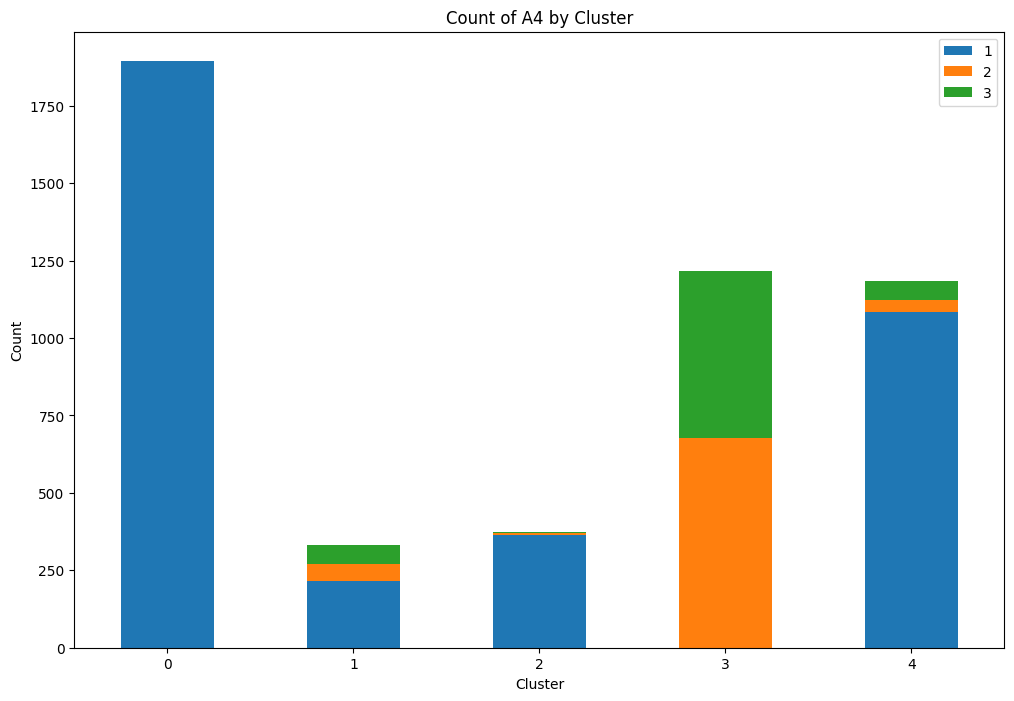

In [100]:
compare_cluster_answers(df_usage, 'cluster', 'A4')

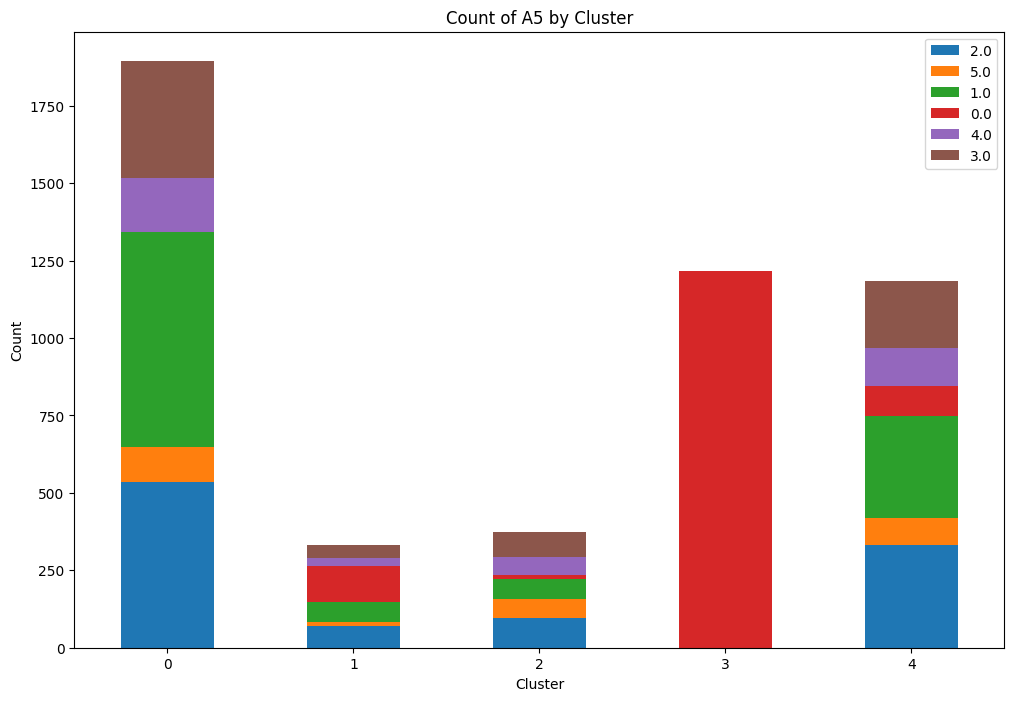

In [101]:
compare_cluster_answers(df_usage, 'cluster', 'A5')

Ceci est confirme par la moyenne de la taille des jardin pour chaque cluster, le cluster 3 ayant une moyenne de 0.  
Cependant cela ne donne pas davantage d'information sur les autres clusters.  
Ainsi, à part pour le cluster 3, **la taille du jardin n'est pas impactant dans le choix clusters**.

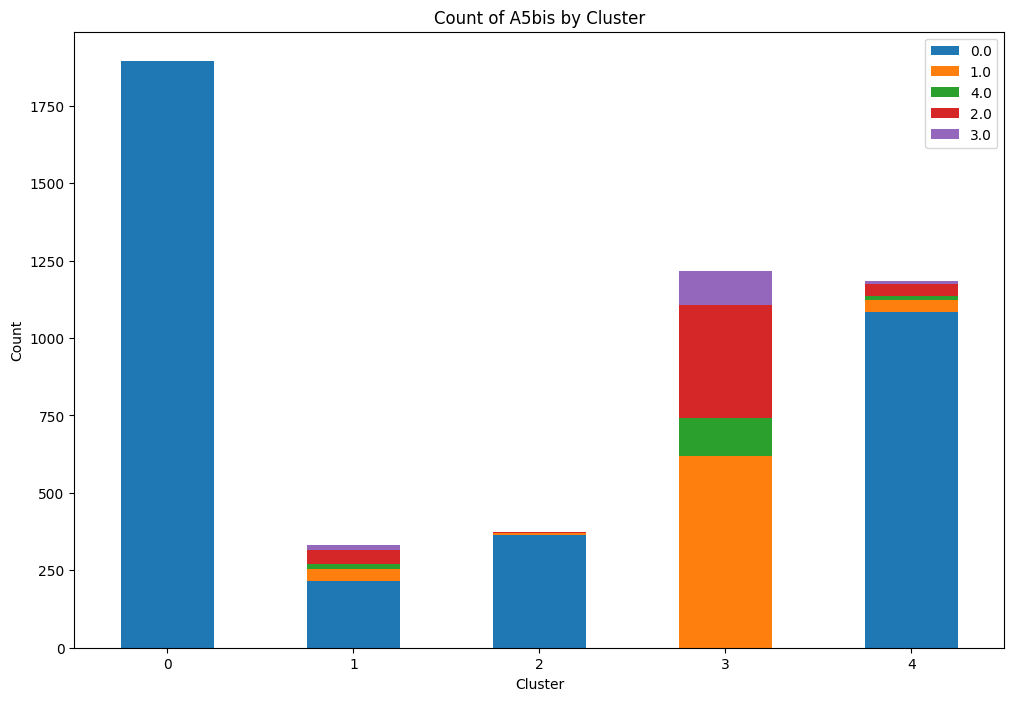

In [102]:
compare_cluster_answers(df_usage, 'cluster', 'A5bis')

Le complementaire. La majorite des terasses ou balcons ont une taille entre 11 et 30 m2.

### Temps passe à l'entretien de l'espace exterieur

Nous avons une suite de question a propos du temps passe à l'entretien de l'espace exterieur en heure:
- `A8_1_slice`: en printemps
- `A8_2_slice`: en ete
- `A8_3_slice`: en automne
- `A8_4_slice`: en hiver


Ces questions font parties des 5 features les plus importantes du cluster 2.

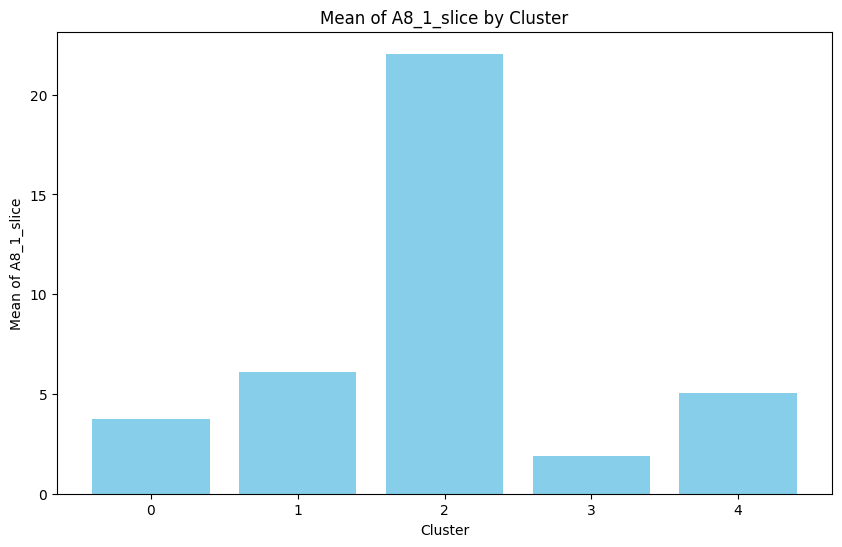

In [103]:
compare_cluster_describe(df_usage, 'cluster', 'A8_1_slice', 'mean')

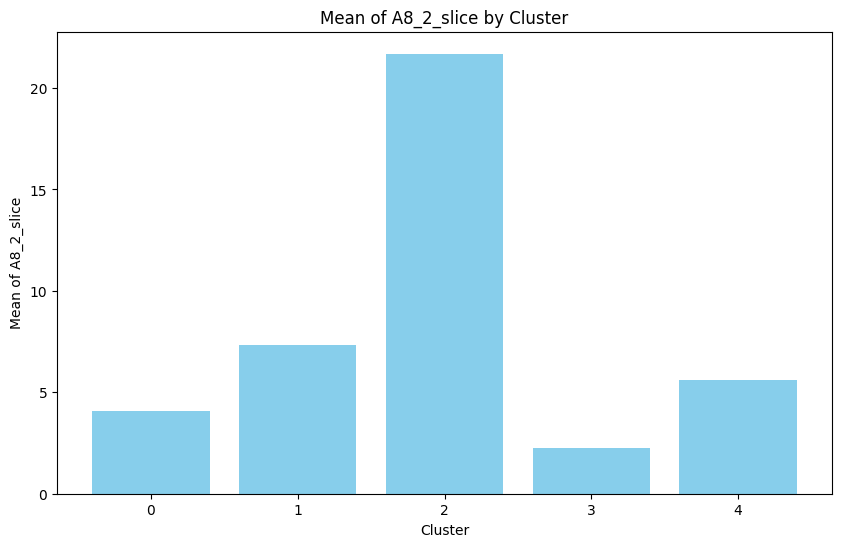

In [104]:
compare_cluster_describe(df_usage, 'cluster', 'A8_2_slice', 'mean')

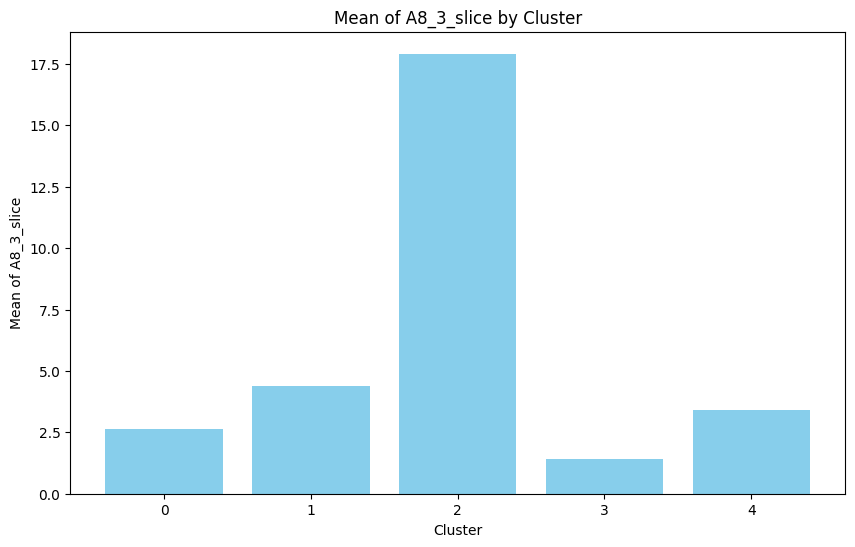

In [105]:
compare_cluster_describe(df_usage, 'cluster', 'A8_3_slice', 'mean')

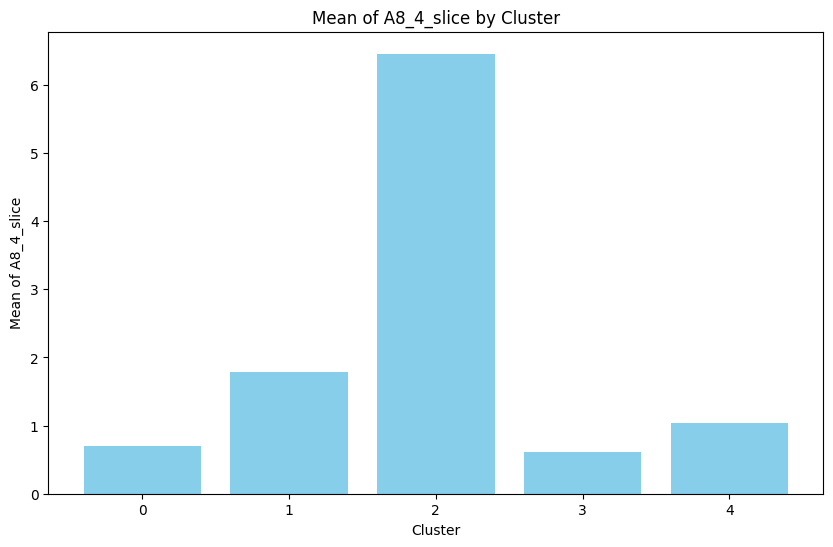

In [106]:
compare_cluster_describe(df_usage, 'cluster', 'A8_4_slice', 'mean')

**Le cluster 2 regroupe les individus qui consacrent beaucoup de temps à l'entretien de l'espace exterieur**.  
On peut egalement noter que les gens passent beaucoup moins de temps en hiver pour l'entretien.

- ### Pret d'outil

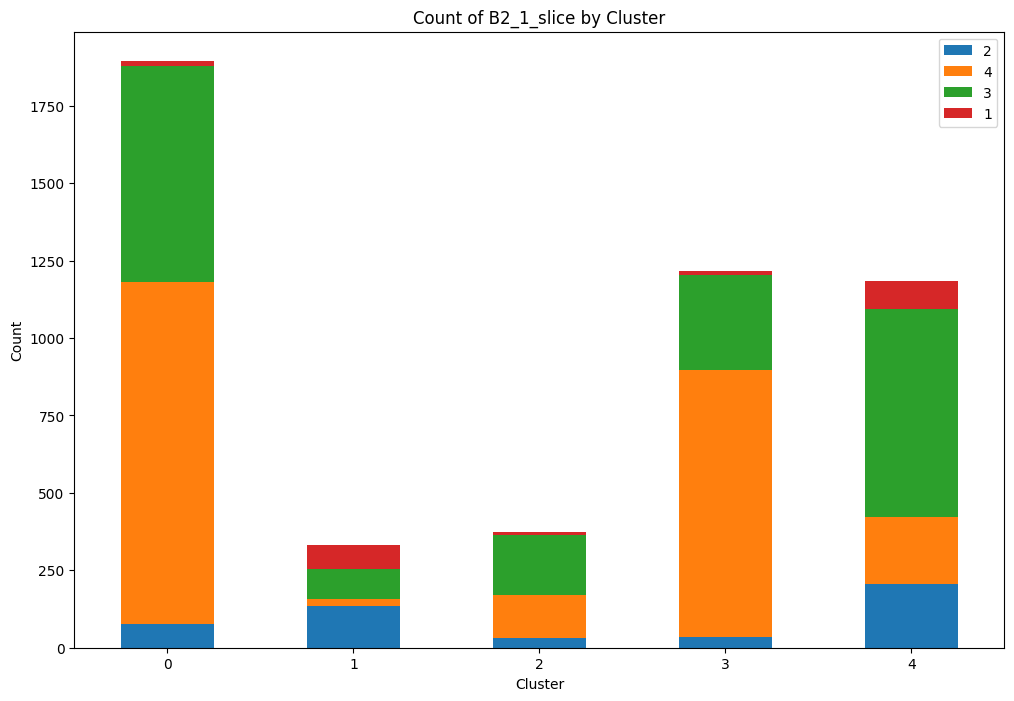

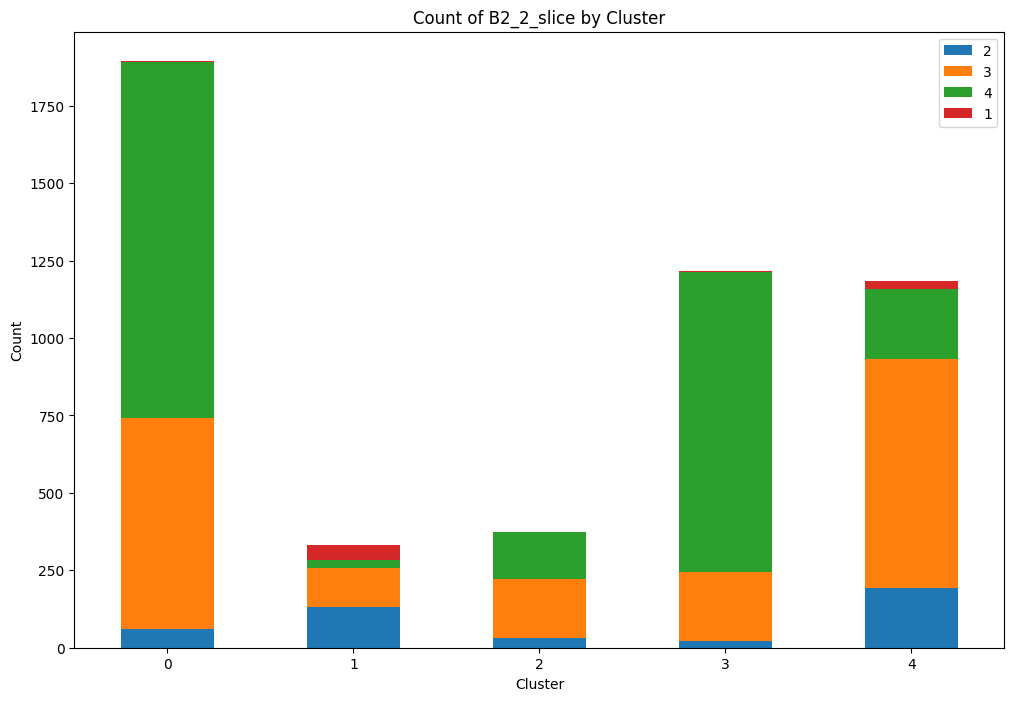

In [107]:
compare_cluster_answers(df_usage, 'cluster', 'B2_1_slice')
compare_cluster_answers(df_usage, 'cluster', 'B2_2_slice')

Les individus du cluster 1 semble le plus preter leurs outils que les autres clusters.

La majorite des individus du cluster 0 et 3 ne prete jamais leurs outils.

La cluster 2 et 4 prete occasionnelement leurs outils.

- ### Emprunt d'outil

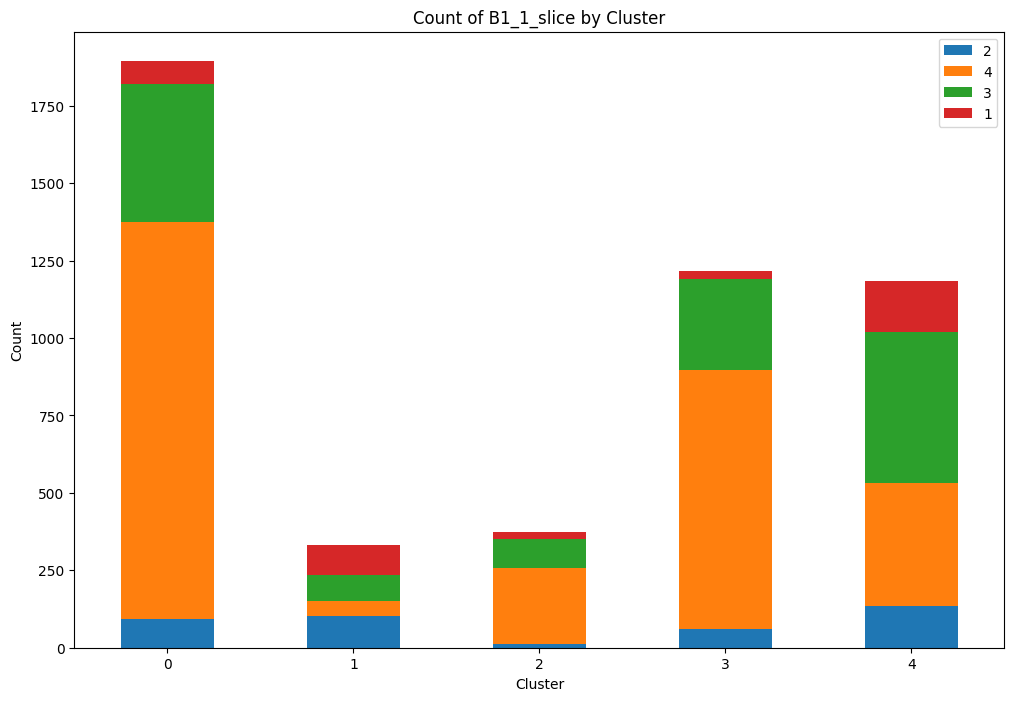

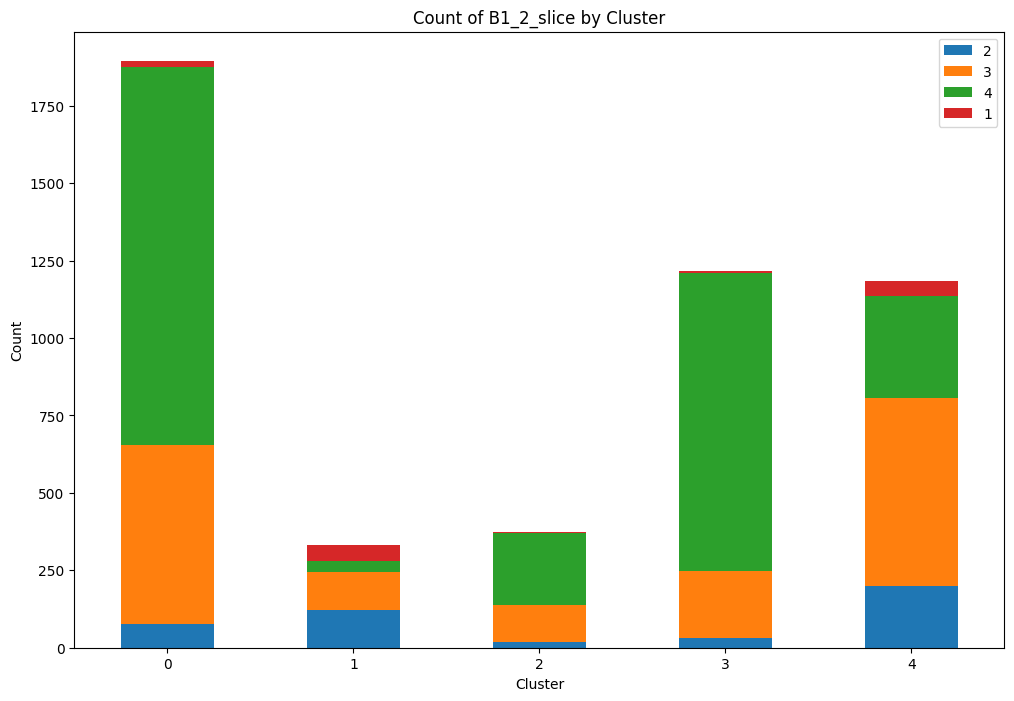

In [108]:
compare_cluster_answers(df_usage, 'cluster', 'B1_1_slice')
compare_cluster_answers(df_usage, 'cluster', 'B1_2_slice')

Nous observons à peu pres le meme motif que pour le pret d'outil. Le cluster 4 en pourcentage emprunte plus d'outil que le cluster 2.

Le cluster 2 ayant le plus d'implication dans le pret/emprunt d'outil, il est tout de meme interessant d'bserver **une hausse d'implication chez le cluster 4 par rapport aux restes**.  

Le cluster 0 et 3 sont ceux qui sont le moins impliques.

- ### Consultation des sites dedies au jardinage

Les questions sur ce theme ont quasiment toutes une feature importance legerement plus eleves que la moyenne.  
On retrouve egalement beaucoup de ces questions dans les features les plus importantes pour les clusters 0, 1 et 4.

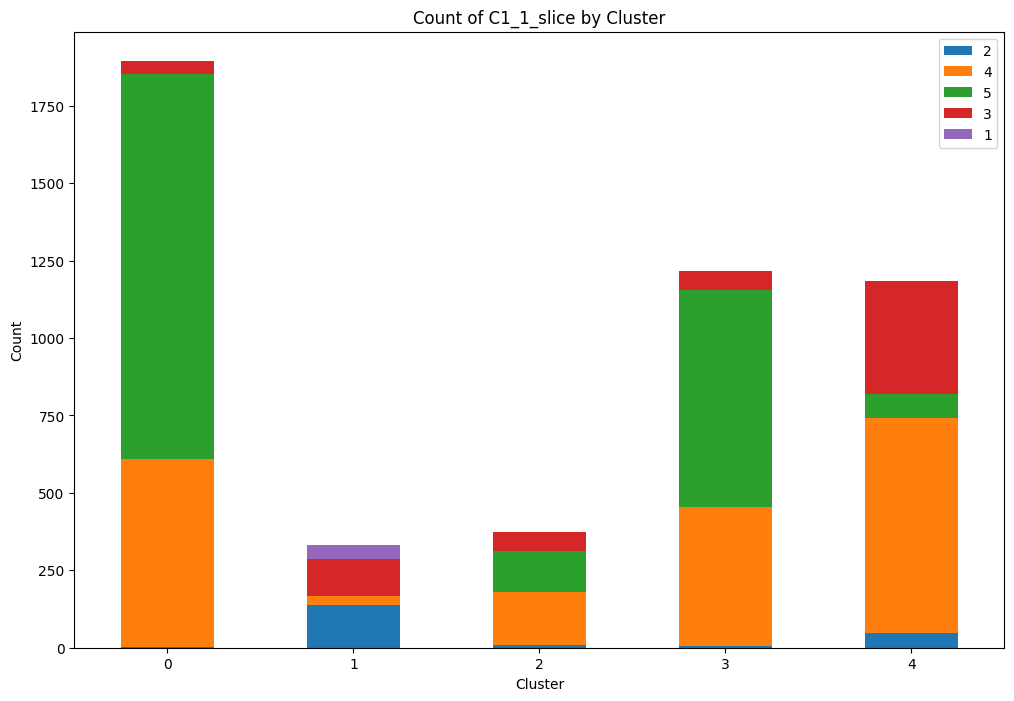

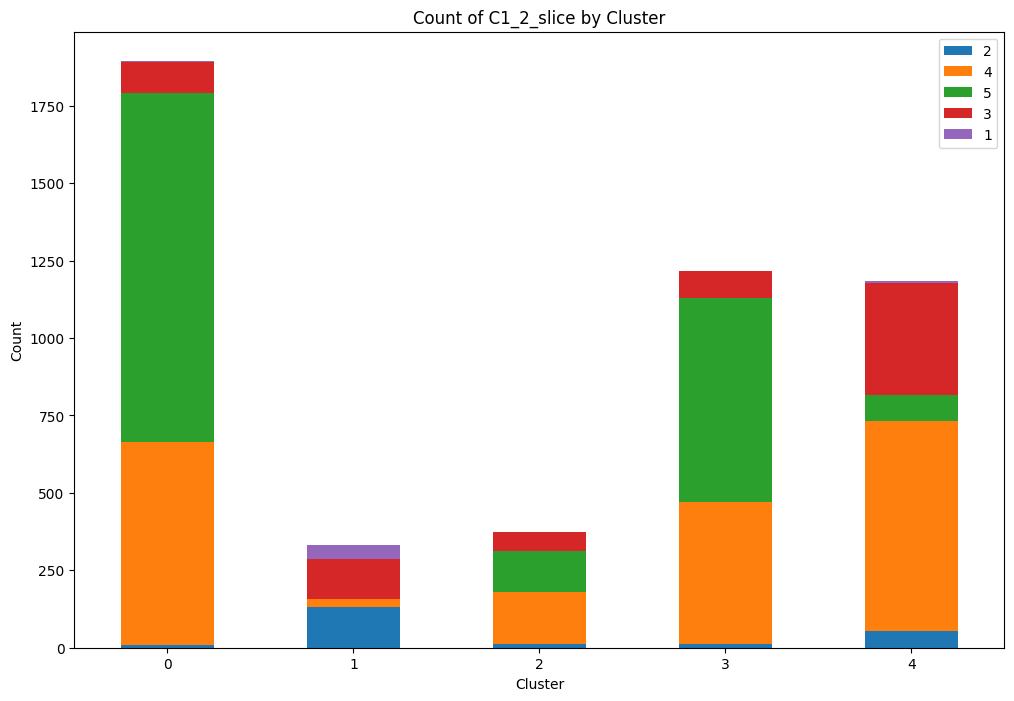

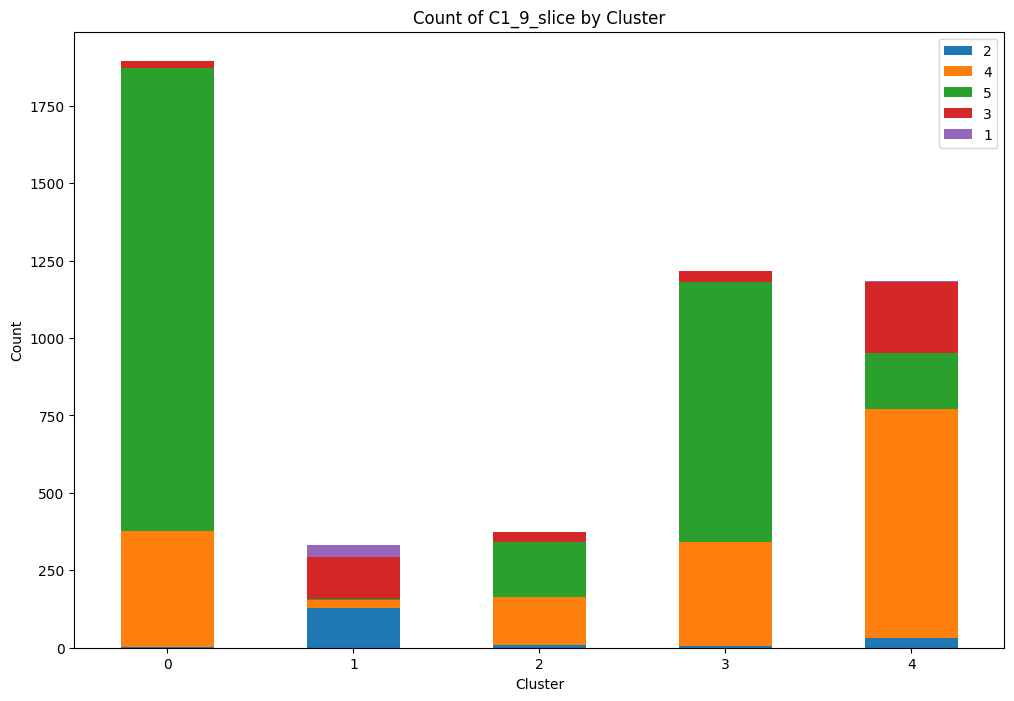

In [109]:
compare_cluster_answers(df_usage, 'cluster', 'C1_1_slice')
compare_cluster_answers(df_usage, 'cluster', 'C1_2_slice')
compare_cluster_answers(df_usage, 'cluster', 'C1_9_slice')

Encore une fois, le cluster 1 semble etre tres actifs, passant le plus de temps sur les reseaux et ensuite c'est le cluster 4 qui passe legerement plus de temps que les autres clusters.

On peut donc en deduire **un engagement fort du cluster 1, modere pour le cluster 4 et tres faible pour les autres clusters**.

### Bilan

- Le cluster 0: rassemble les individus ayant juste un jardin et passe tres peu de temps a l'entretien de leur jardin et sur les reseaux. **C'est le groupe le moins impliques**.
- Le cluster 1: rassemble les individus les plus actifs sur les reseaux et meme pour emprunter/preter des outils ou autres. **C'est le groupe le plus interesse par des offres de jardinage**.
- Le cluster 2: rassemble les individus qui passent le plus de temps a entretenir leur espace exterieur. On peut noter que c'est gens passent beaucoup de temps a entretenir leur espaces exterieurs mais n'essaye pas de beneficier des offres de reseaux ou d'echange d'outils. **C'est le groupe d'individu qui ont potentiellement le plus besoin d'offre pour optimiser leur temps d'entretien**.
- Le cluster 3: rassemble les individus n'ayant pas de jardin. **C'est le groupe à cibler pour des offres concernant les balcons et les terasses**.
- Le cluster 4: rassemble les individus moderement impliques sur les reseaux ou pour l'emprunt/pret d'outil. **C'est le groupe potentiellement susceptible d'etre interesses par des offres de jardinage**.

## Attitude Clustering

In [110]:
kmeans_attitude = make_clusters(df_attitude, 4)

### Importance des features global

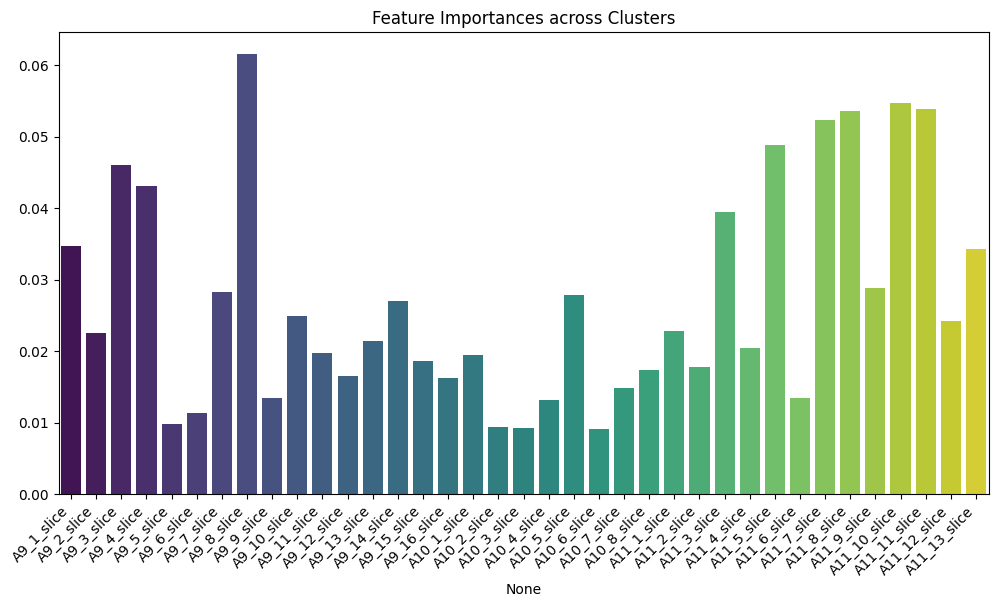

In [111]:
feature_importance(df_attitude)

### Importance des features par cluster

In [112]:
features_per_cluster(df_attitude.iloc[:, 3:-1], kmeans_attitude, 4)

Most Important Features by Cluster:
Cluster 0: ['A9_3_slice', 'A9_8_slice', 'A9_4_slice', 'A9_2_slice', 'A9_7_slice']
Cluster 1: ['A11_8_slice', 'A11_5_slice', 'A11_7_slice', 'A11_3_slice', 'A11_10_slice']
Cluster 2: ['A9_8_slice', 'A9_3_slice', 'A9_4_slice', 'A9_10_slice', 'A9_2_slice']
Cluster 3: ['A11_5_slice', 'A11_7_slice', 'A11_10_slice', 'A11_3_slice', 'A11_1_slice']


- ## Analyse des features

- ### Interet envers l'amenagement

Les questions de type `A9` donne une idee de l'interet porter par les individus sur leur espace exterieur et de leur amenagement. Il y'a un total de 16 questions, nous fournissant donc beaucoup d'informations.  
Les questions `A9_3_slice`, `A9_4_slice` et `A9_8_slice` sont trois questions ayant la plus grande feature importances parmi toutes les autres features, analysant les de plus pres.
- `A9_3_slice`: L'individu recherche souvent des informations sur l’aménagement des espaces extérieurs
- `A9_4_slice`: L'individu recherche souvent des informations sur l’entretien des espaces extérieurs
- `A9_8_slice`: L'individu privilégie les produits éco-responsables dans l’aménagement et l’entretien des espaces extérieurs

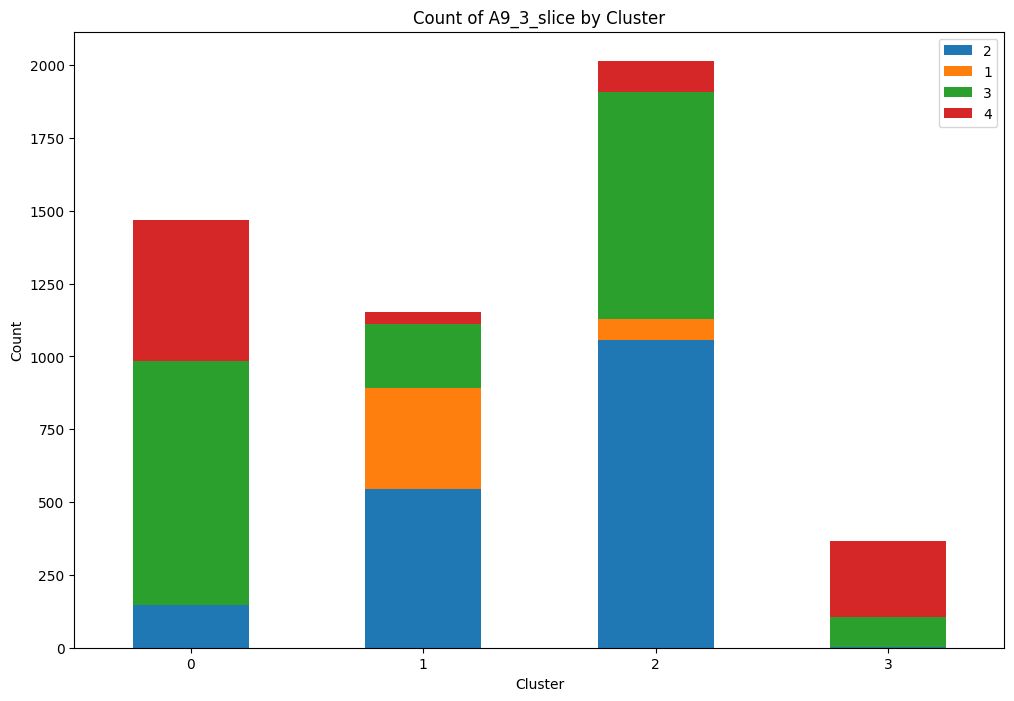

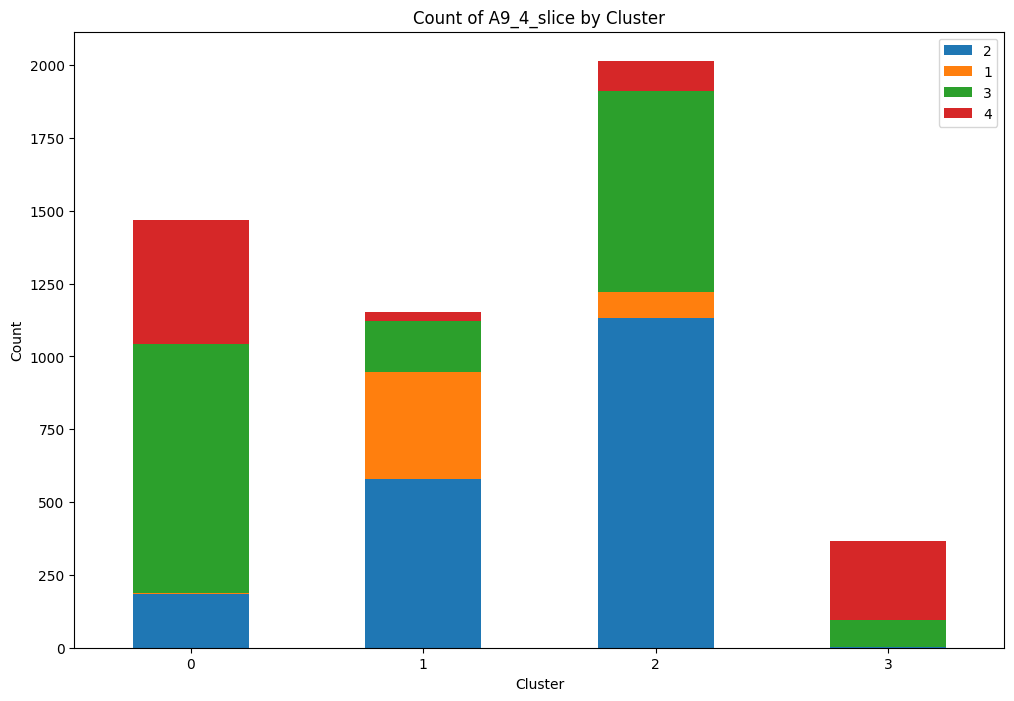

In [113]:
compare_cluster_answers(df_attitude, 'cluster', 'A9_3_slice')
compare_cluster_answers(df_attitude, 'cluster', 'A9_4_slice')

On remarque que le cluster 1 rassemble les gens les plus interesses par l'amenagement exterieur que les autres. En effet, il effectue le plus de recherche sur l'amenagement et l'entretien.

Au contraire, le cluster 3 ne semble pas interesse.

Le cluster 2 semble plus interesse par l'amenagement que le cluster 0.

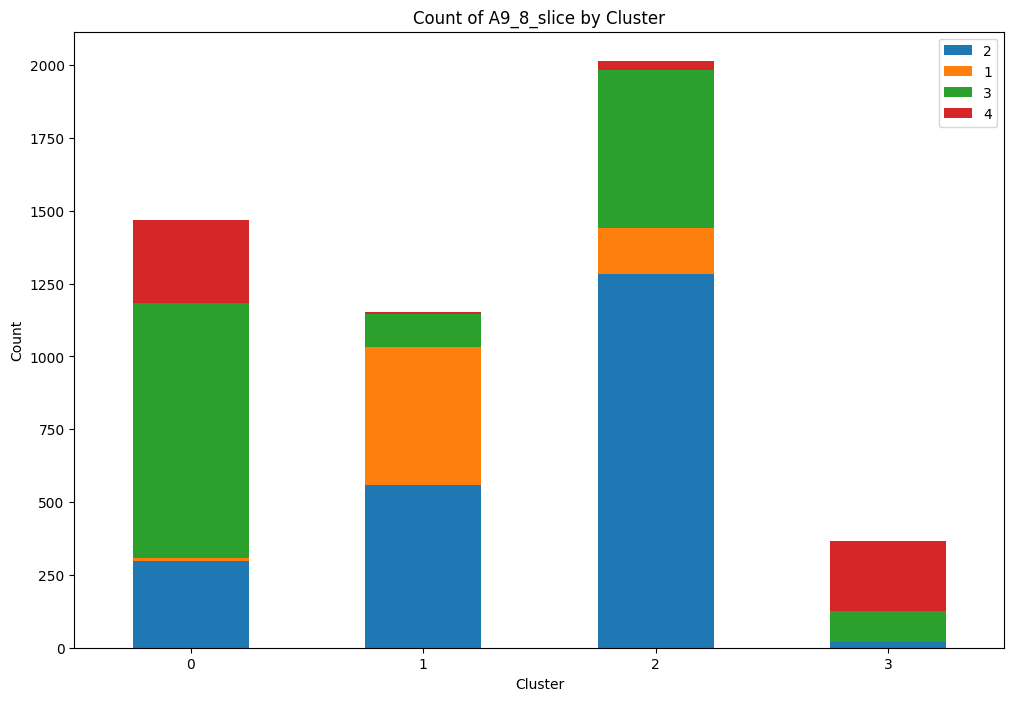

In [114]:
compare_cluster_answers(df_attitude, 'cluster', 'A9_8_slice')

Similairement, nous observons que le meme pattern pour l'investissement dans l'amenagement.

- ### Vision sur l'utilite des espaces exterieurs

Les questions de la catégorie `A10` nous fournissent des informations sur les opinions des individus en ce qui concerne l'utilité de leurs espaces extérieurs.
10 11 8 7 5
Les questions avec le plus d'importance dans cette categorie sont les suivantes:
- `A10_5_slice`: Les espaces extérieurs sont des vecteurs de bonheur et de plaisirs
- `A10_1_slice`: Les espaces extérieurs permettent de rester en contact avec la nature
- `A10_8_slice`: Les espaces extérieurs vous permettent de faire des économies grâce à la culture de fruits et légumes



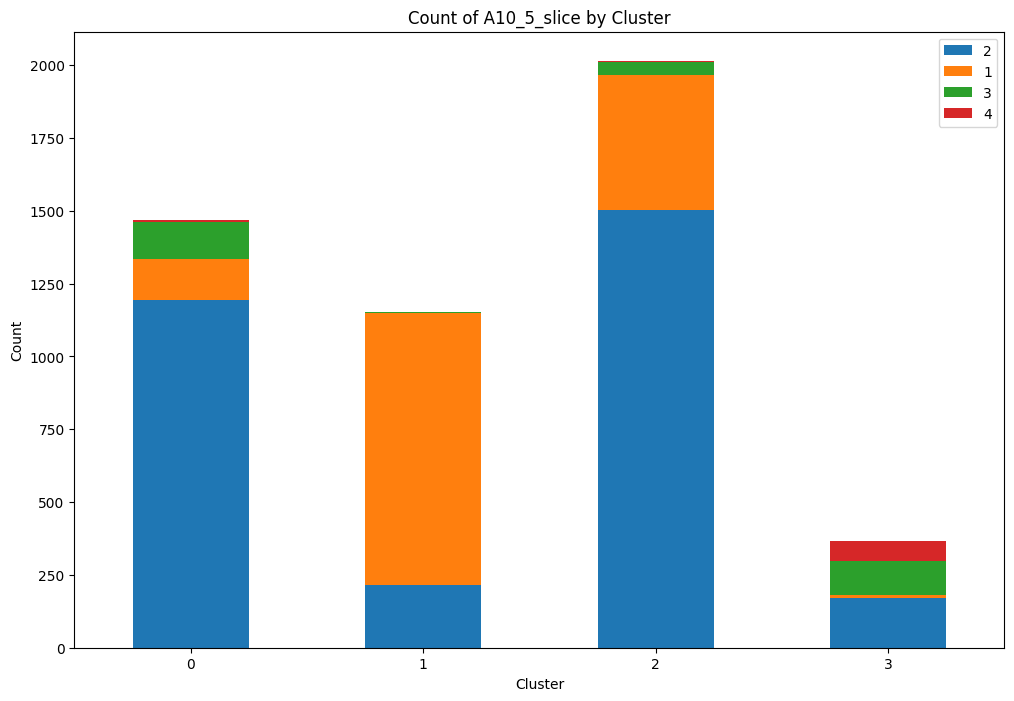

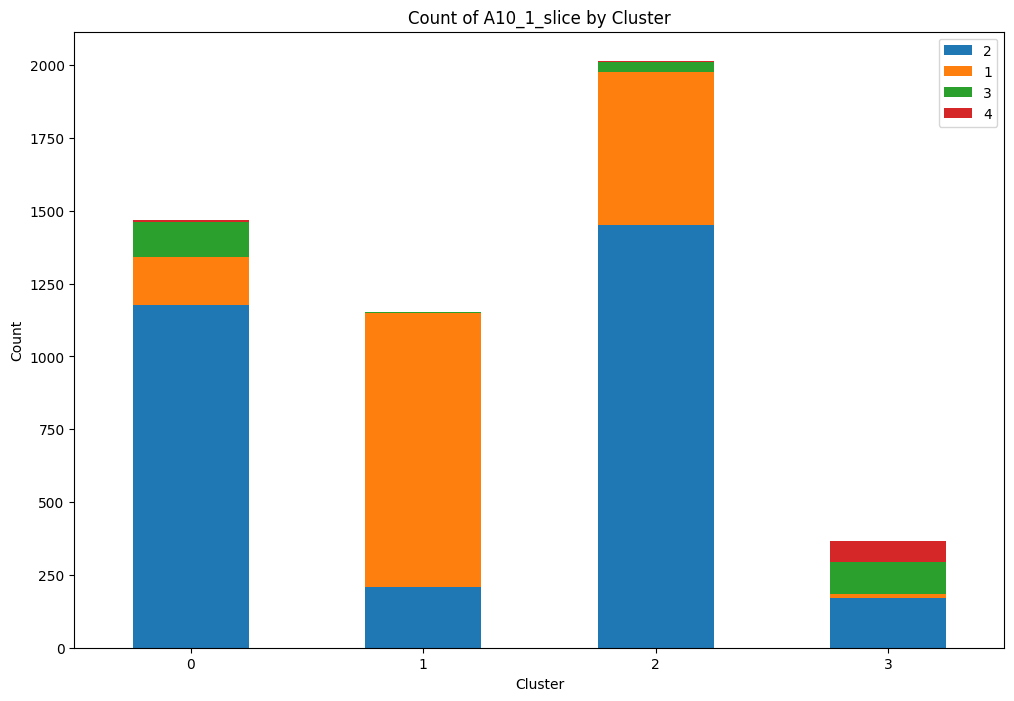

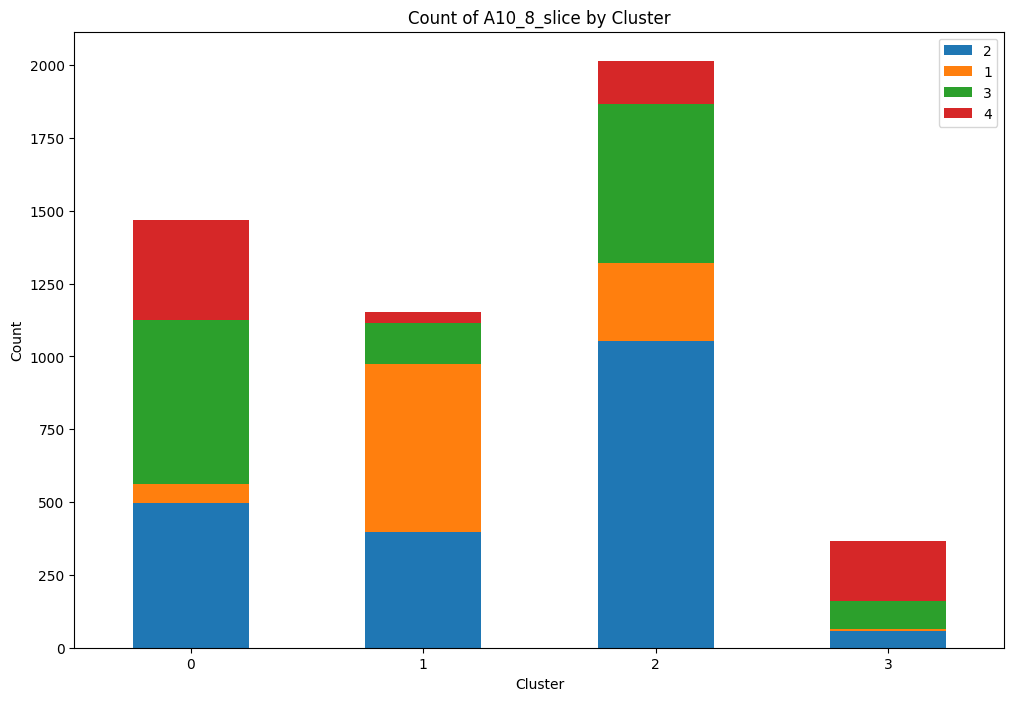

In [115]:
compare_cluster_answers(df_attitude, 'cluster', 'A10_5_slice')
compare_cluster_answers(df_attitude, 'cluster', 'A10_1_slice')
compare_cluster_answers(df_attitude, 'cluster', 'A10_8_slice')

Nous remarquons également que le cluster 1 et 3 sont les extremes.  
Le cluster 2 semble plus se rapprocher du 1 et le cluster 0 avec le cluster 3.

- ### Perspective émotionnelle des espaces exterieurs

Les questions de la catégorie `A11` nous fournissent des informations sur les opinions des individus en ce qui concerne leur perspaces extérieurs.

Les questions avec le plus d'importance dans cette categorie sont les suivantes:


Les questions avec le plus d'importance dans cette categorie sont les suivantes:
- `A11_10_slice`: Un moyen de réaliser jusqu’au bout quelque chose de vos propres mains
- `A11_11_slice`: Un moyen de transmettre des connaissances, des pratiques qu’il est indispensable de perpétuer
- `A11_8_slice`: Votre espace favori de loisirs et de liberté
- `A11_7_slice`: Votre contact privilégié avec le vert, la nature
- `A11_5_slice`: Un moyen de se resourcer, de refaire le plein d’énergie

Ces questions ont tous une importance elevee.

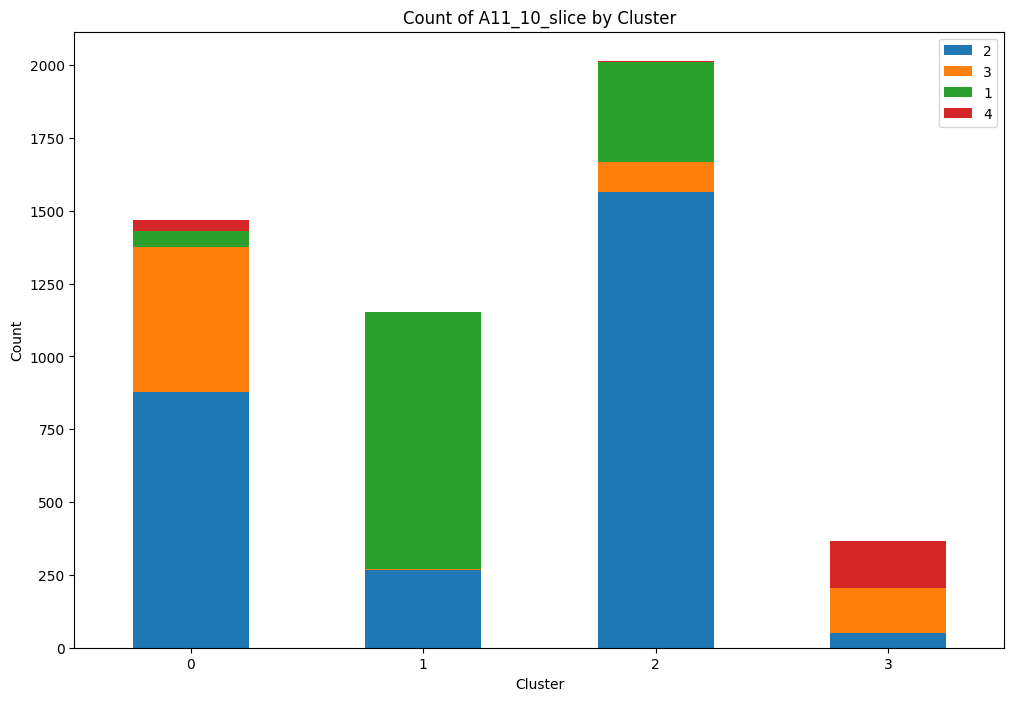

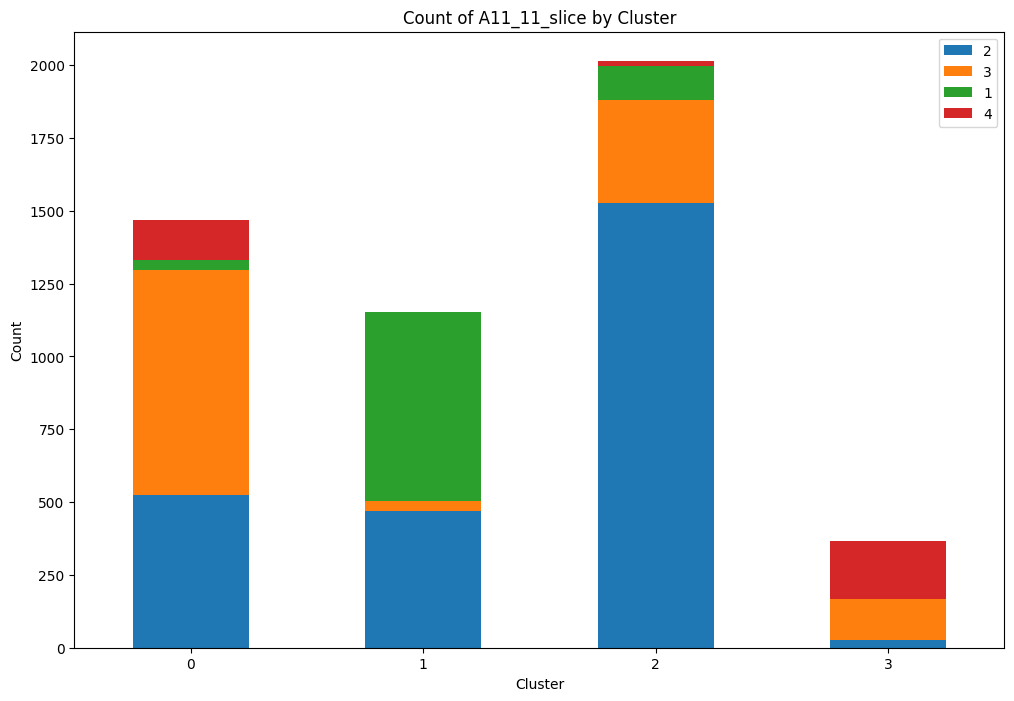

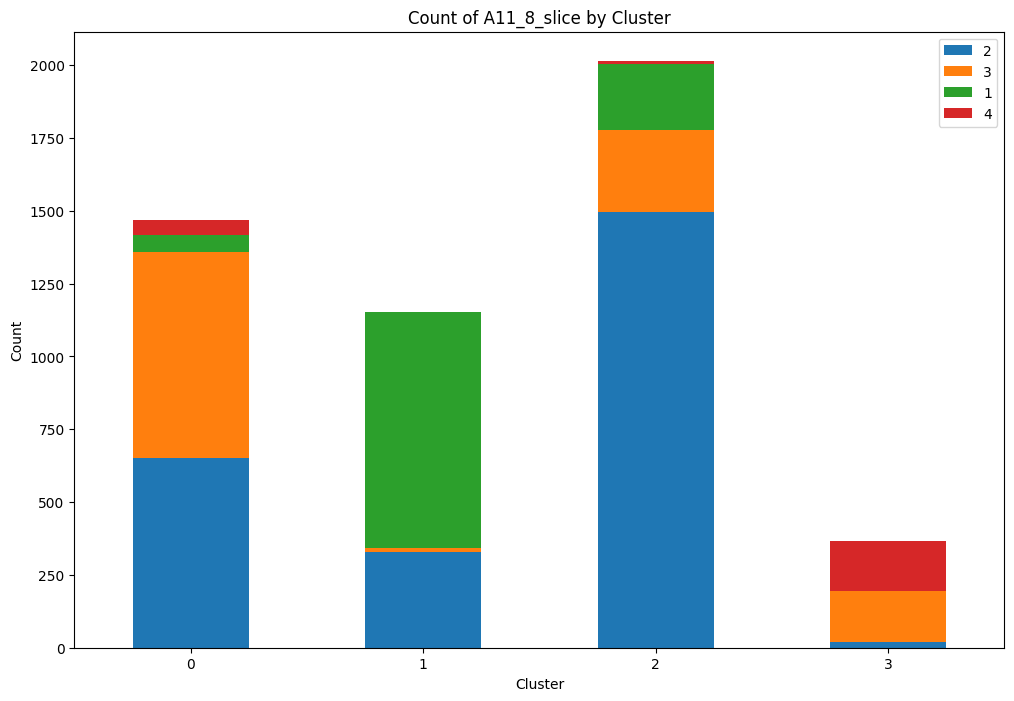

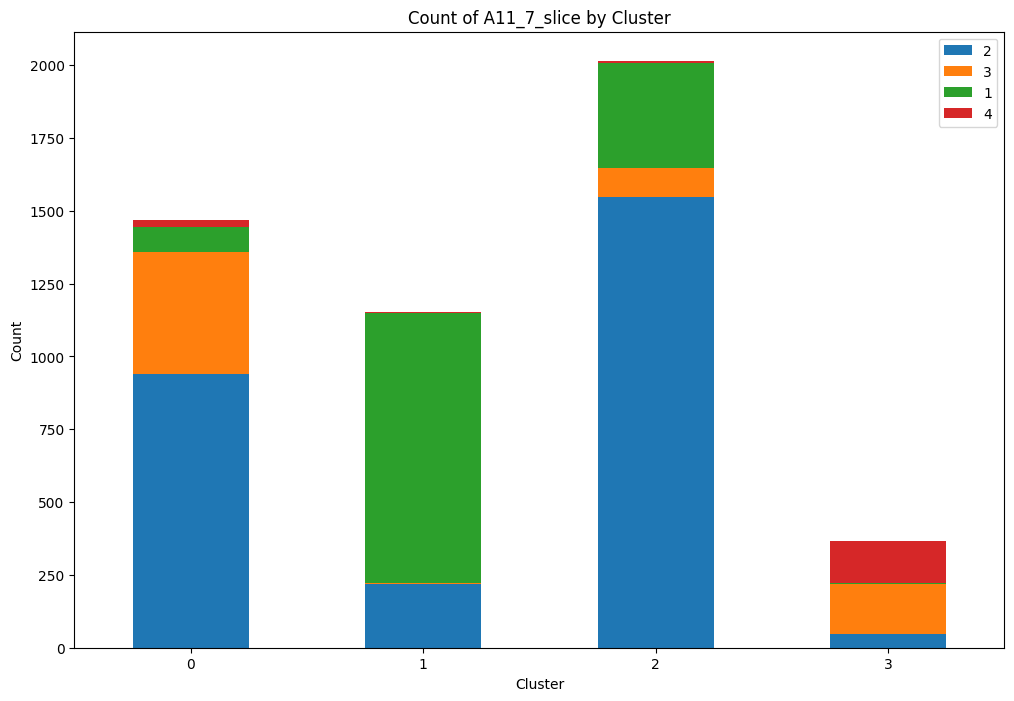

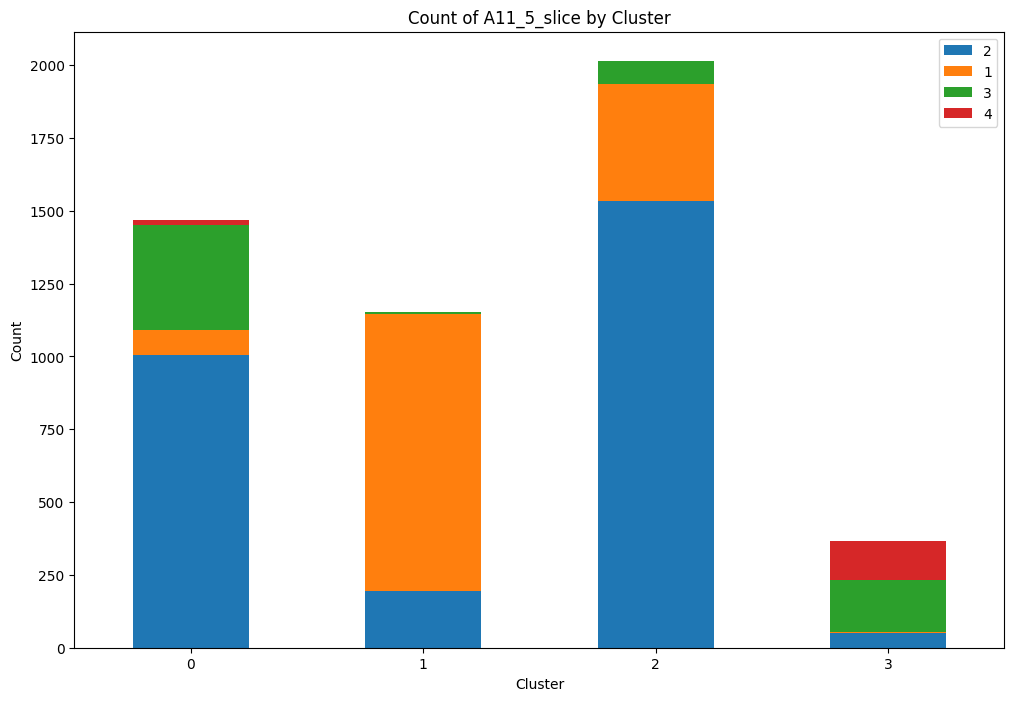

In [116]:
compare_cluster_answers(df_attitude, 'cluster', 'A11_10_slice')
compare_cluster_answers(df_attitude, 'cluster', 'A11_11_slice')
compare_cluster_answers(df_attitude, 'cluster', 'A11_8_slice')
compare_cluster_answers(df_attitude, 'cluster', 'A11_7_slice')
compare_cluster_answers(df_attitude, 'cluster', 'A11_5_slice')

Encore une fois, nous observons que le cluster 1 voit tres positivement leur espaces exterieurs et le cluster 3 pas du tout.

Le cluster 2 se rapproche du cluster 1 mais est plus modere dans ses reponses et le cluster 3 est neutre.

### Bilan
- Le cluster 0: rassemble les individus ayant une perspective legerement positive voir neutre sur l'espace exterieur et son amenagement. **C'est le groupe sans opinions prononcees**.
- Le cluster 1: rassemble les individus qui portent un grand interet a leur espace exterieur, voit beaucoup d'utilite a avoir un espace exterieur et y sont tres attaches. **C'est le groupe le plus engage**.
- Le cluster 2: rassemble les individus qui portent un leger interet a leur espace exterieur. **C'est le groupe qui legerement engage**.
- Le cluster3: rassemble les individues qui ne porte aucun interet a leur espace exterieur. **C;est le groupe le moins impliques**.